In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
# 🔍 cek GPU
print("GPU available:", tf.config.list_physical_devices('GPU'))
print("Default device:", tf.test.gpu_device_name())
print("TensorFlow version:", tf.__version__)


GPU available: []
Default device: 
TensorFlow version: 2.20.0


In [5]:
# Path ke dataset (ubah sesuai lokasi folder kamu)
train_dir = r"D:\Tugas Akhir\Dataset\Testing"
test_dir = r"D:\Tugas Akhir\Dataset\Training"

# Ukuran gambar sesuai input MobileNetV2
img_size = (224, 224)
batch_size = 32

# Load dataset train & test
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size
)

# Ambil nama kelas
class_names = train_ds.class_names
print("Classes:", class_names)  # Harusnya: ['glioma', 'meningioma', 'no_tumor', 'pituitary']

# Optional: bikin dataset lebih cepat (prefetch & cache)
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 1311 files belonging to 4 classes.
Found 5712 files belonging to 4 classes.
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [6]:
# --- 1. Load MobileNetV2 tanpa fully connected layer (include_top=False) ---
base_model = MobileNetV2(weights="imagenet", include_top=False, pooling="avg")

# --- 2. Function untuk ekstraksi fitur ---
def extract_features(dataset):
    features = []
    labels = []
    for images, labs in dataset:
        # Preprocess gambar
        imgs_preprocessed = preprocess_input(images)
        # Ekstraksi fitur
        feats = base_model(imgs_preprocessed, training=False)
        features.append(feats.numpy())
        labels.append(labs.numpy())
    # Gabungkan semua batch jadi satu array
    features = np.concatenate(features)
    labels = np.concatenate(labels)
    return features, labels

# --- 3. Ekstraksi fitur dari train dan test dataset ---
X_train, y_train = extract_features(train_ds)
X_test, y_test = extract_features(test_ds)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# --- 4. Simpan hasil ke file numpy ---
np.save("X_train.npy", X_train)
np.save("y_train.npy", y_train)
np.save("X_test.npy", X_test)
np.save("y_test.npy", y_test)

print("Fitur berhasil diekstrak & disimpan!")

C:\Users\Rtx3070\AppData\Local\Temp\ipykernel_30032\1141702965.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights="imagenet", include_top=False, pooling="avg")


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
X_train shape: (1311, 1280)
y_train shape: (1311,)
X_test shape: (5712, 1280)
y_test shape: (5712,)
Fitur berhasil diekstrak & disimpan!


# Batas TesTing

In [7]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
import numpy as np
import tensorflow.keras.utils as utils

# Muat ulang model TANPA pooling global di akhir
base_model_vis = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Daftar nama layer yang ingin kita lihat outputnya
# Anda bisa tambahkan/ubah nama layer di sini. Lihat `base_model_vis.summary()` untuk daftar lengkap.
layer_names = [
    'Conv1_relu',           # Layer konvolusi pertama (fitur paling dasar)
    'block_1_expand_relu',  # Blok awal (setelah ekspansi 1x1)
    'block_3_depthwise_relu', # Sedikit lebih dalam (setelah depthwise conv)
    'block_6_project_BN',   # Di tengah model (setelah proyeksi 1x1)
    'block_13_expand_relu', # Menjelang akhir model
    'out_relu'              # Layer konvolusi 1x1 terakhir sebelum pooling
]

# Buat model baru yang output-nya adalah feature map dari layer-layer di atas
layer_outputs = [base_model_vis.get_layer(name).output for name in layer_names]
visualization_model = Model(inputs=base_model_vis.input, outputs=layer_outputs)

print("Model visualisasi berhasil dibuat.")

Model visualisasi berhasil dibuat.


Gambar sampel diambil. Label Asli: meningioma


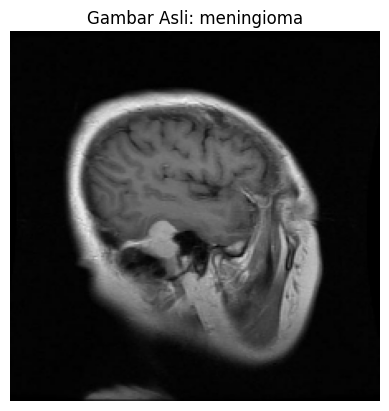

In [8]:
# Ambil satu batch dari dataset latih (dari sel [4] atau [6])
image_batch, label_batch = next(iter(train_ds))

# Ambil 1 gambar saja dari batch (kita tetap butuh dimensi batch, jadi [0:1])
sample_image = image_batch[0:1] 
true_label = class_names[label_batch[0]]

# Preprocess gambar sesuai kebutuhan MobileNetV2
sample_image_preprocessed = preprocess_input(sample_image)

print(f"Gambar sampel diambil. Label Asli: {true_label}")
plt.imshow(sample_image[0].numpy().astype("uint8"))
plt.title(f"Gambar Asli: {true_label}")
plt.axis("off")
plt.show()

In [9]:
# Dapatkan feature maps (aktivasi) dari model visualisasi
feature_maps = visualization_model.predict(sample_image_preprocessed)

print(f"Total feature map yang didapat: {len(feature_maps)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Total feature map yang didapat: 6



ANALISIS LAYER: Conv1_relu


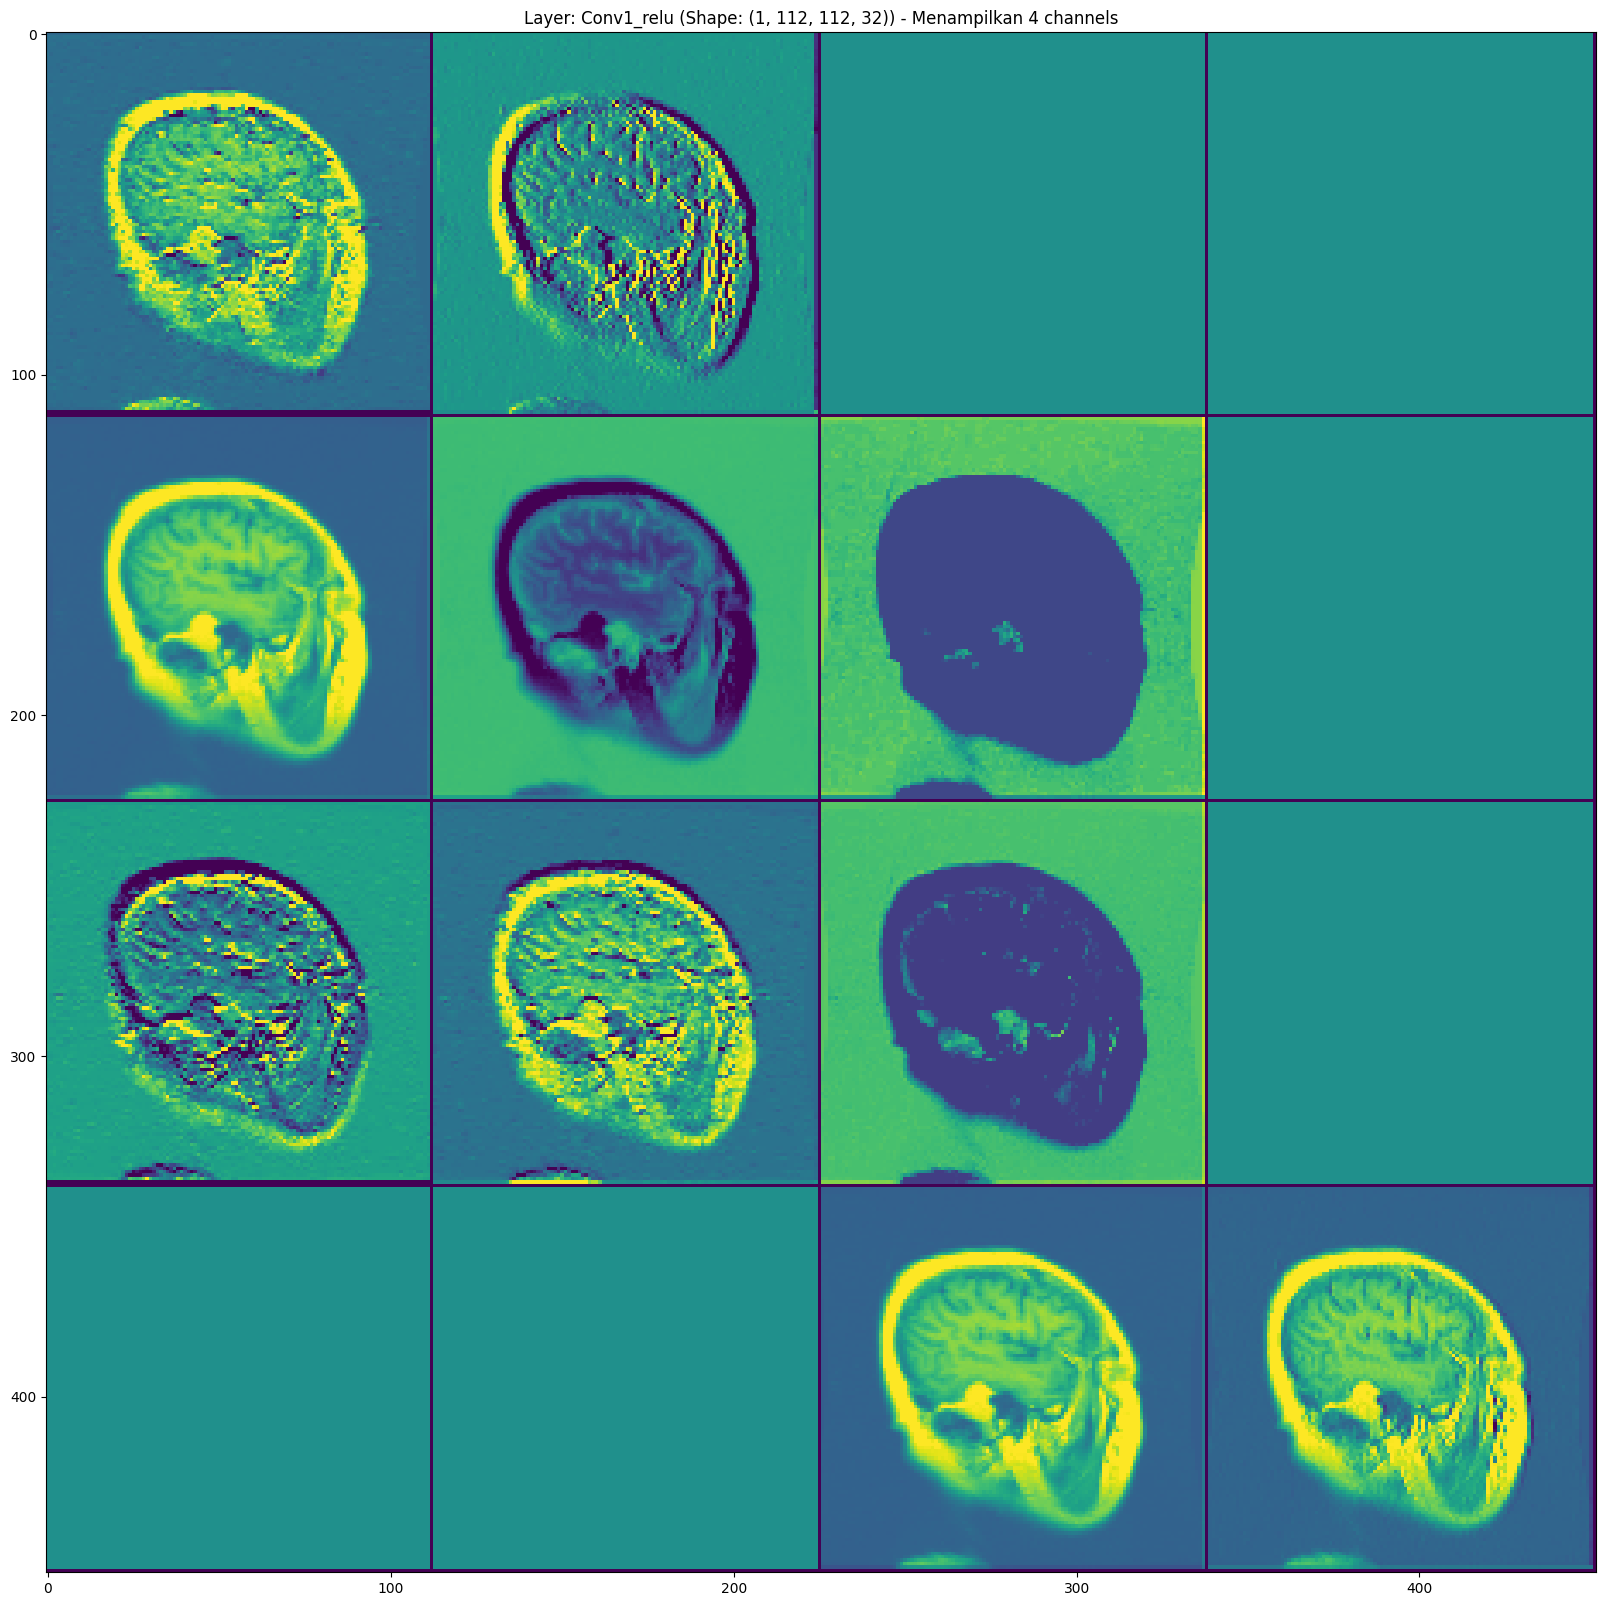

**Penjelasan (Conv1_relu):** Ini adalah output dari layer konvolusi standar pertama.
Keluaran ini menunjukkan fitur-fitur paling dasar yang dideteksi model.
Setiap kotak kecil (channel) fokus pada pola sederhana yang berbeda, seperti:
  - Detektor tepi (garis lurus, lengkungan)
  - Detektor tekstur (pola berulang, bintik-bintik)
  - Detektor gradien warna atau kecerahan.
Banyak channel mungkin terlihat kosong (hitam) jika fitur tersebut tidak aktif pada gambar ini.

ANALISIS LAYER: block_1_expand_relu


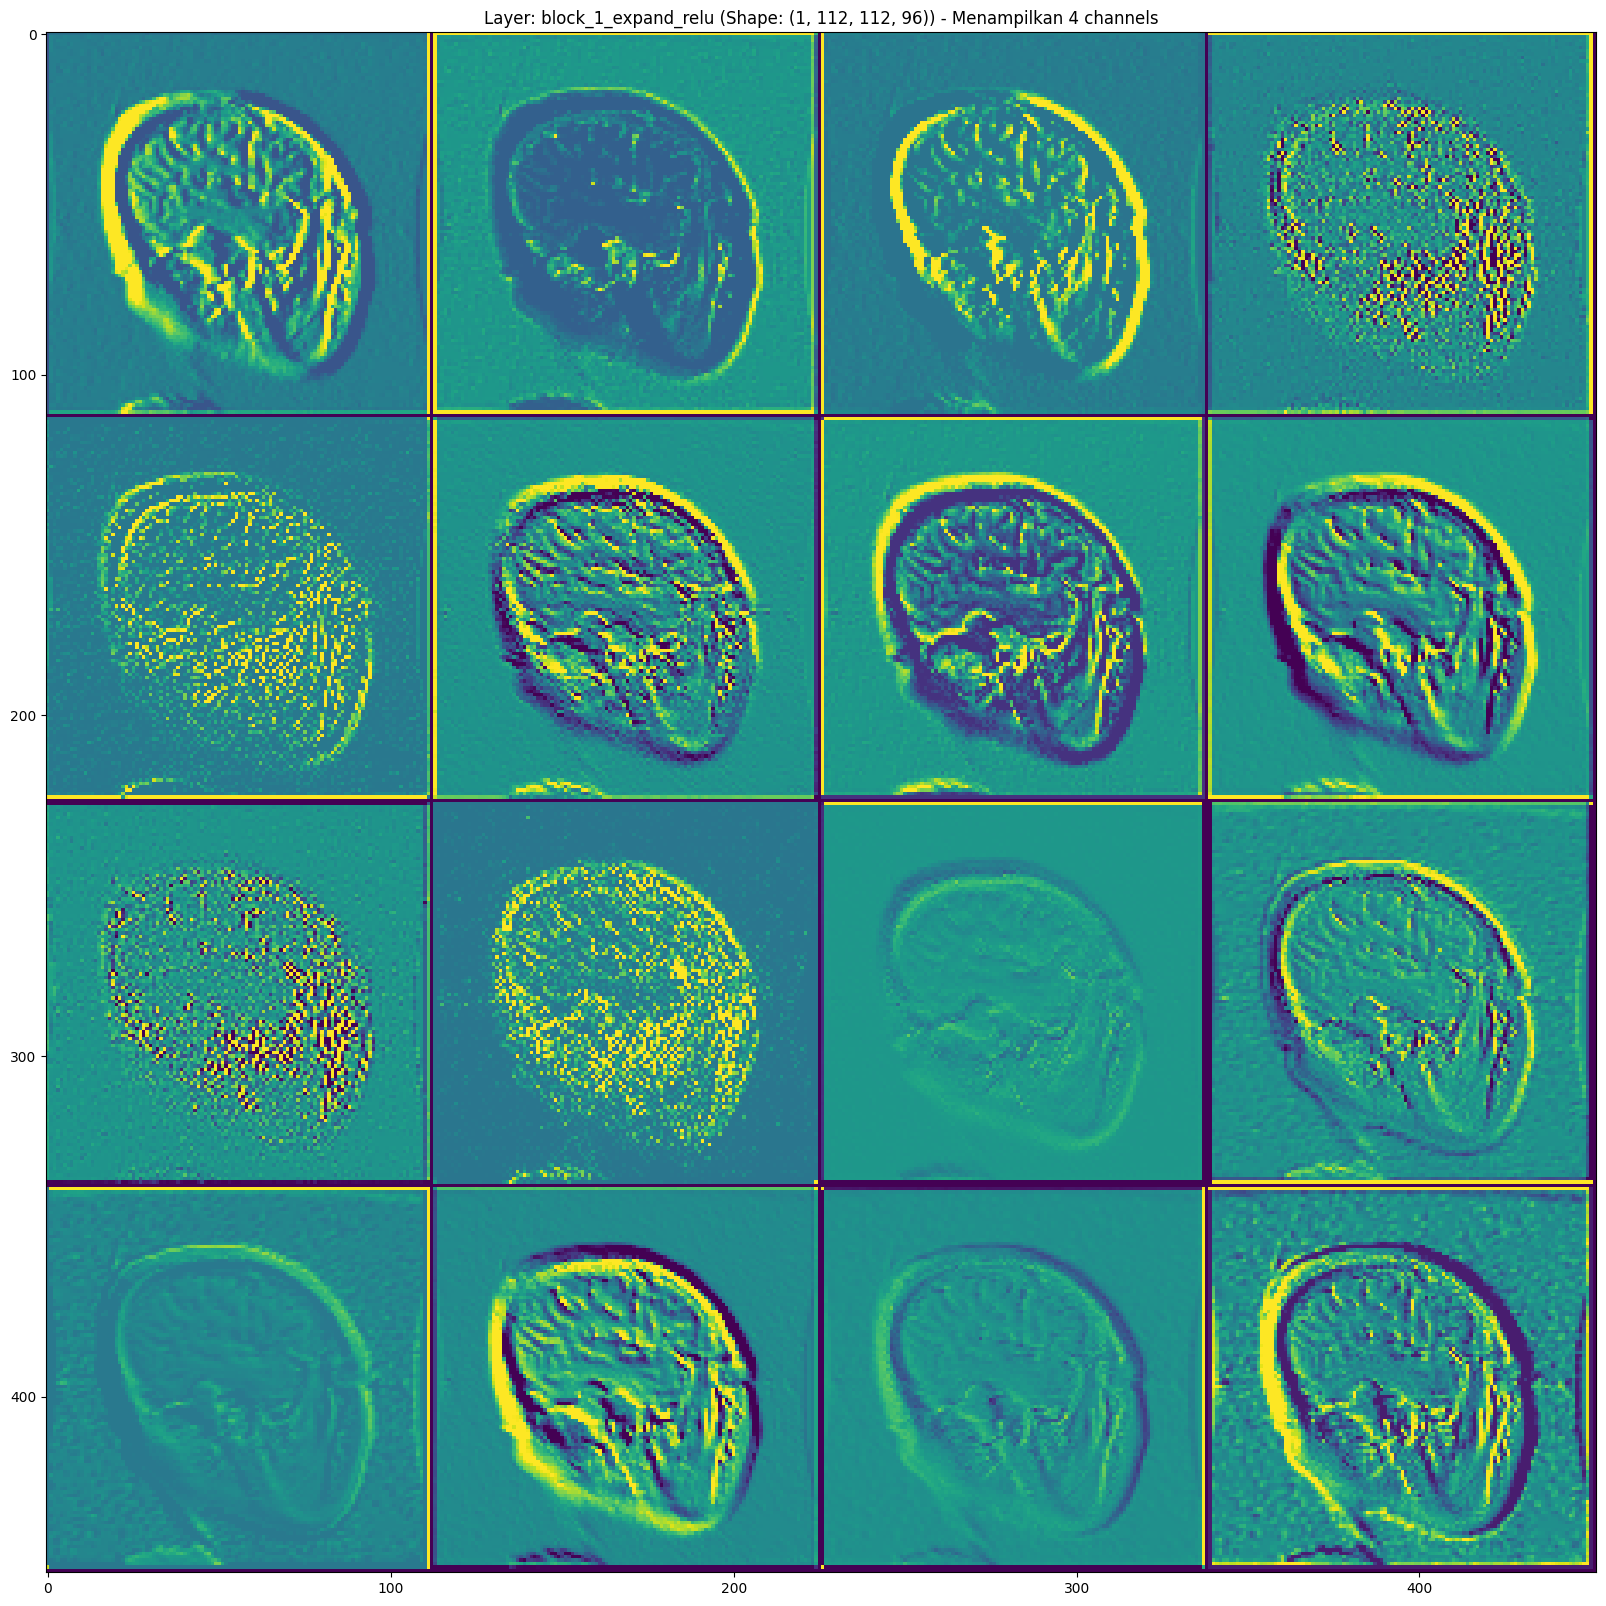

**Penjelasan (block_1_expand_relu):** Ini adalah layer di blok-blok awal MobileNetV2.
Model mulai menggabungkan fitur-fitur dasar (tepi, tekstur) dari layer sebelumnya.
Fitur di sini masih cukup sederhana, mungkin merepresentasikan sudut, lengkungan yang lebih kompleks, atau area dengan tekstur tertentu.

ANALISIS LAYER: block_3_depthwise_relu


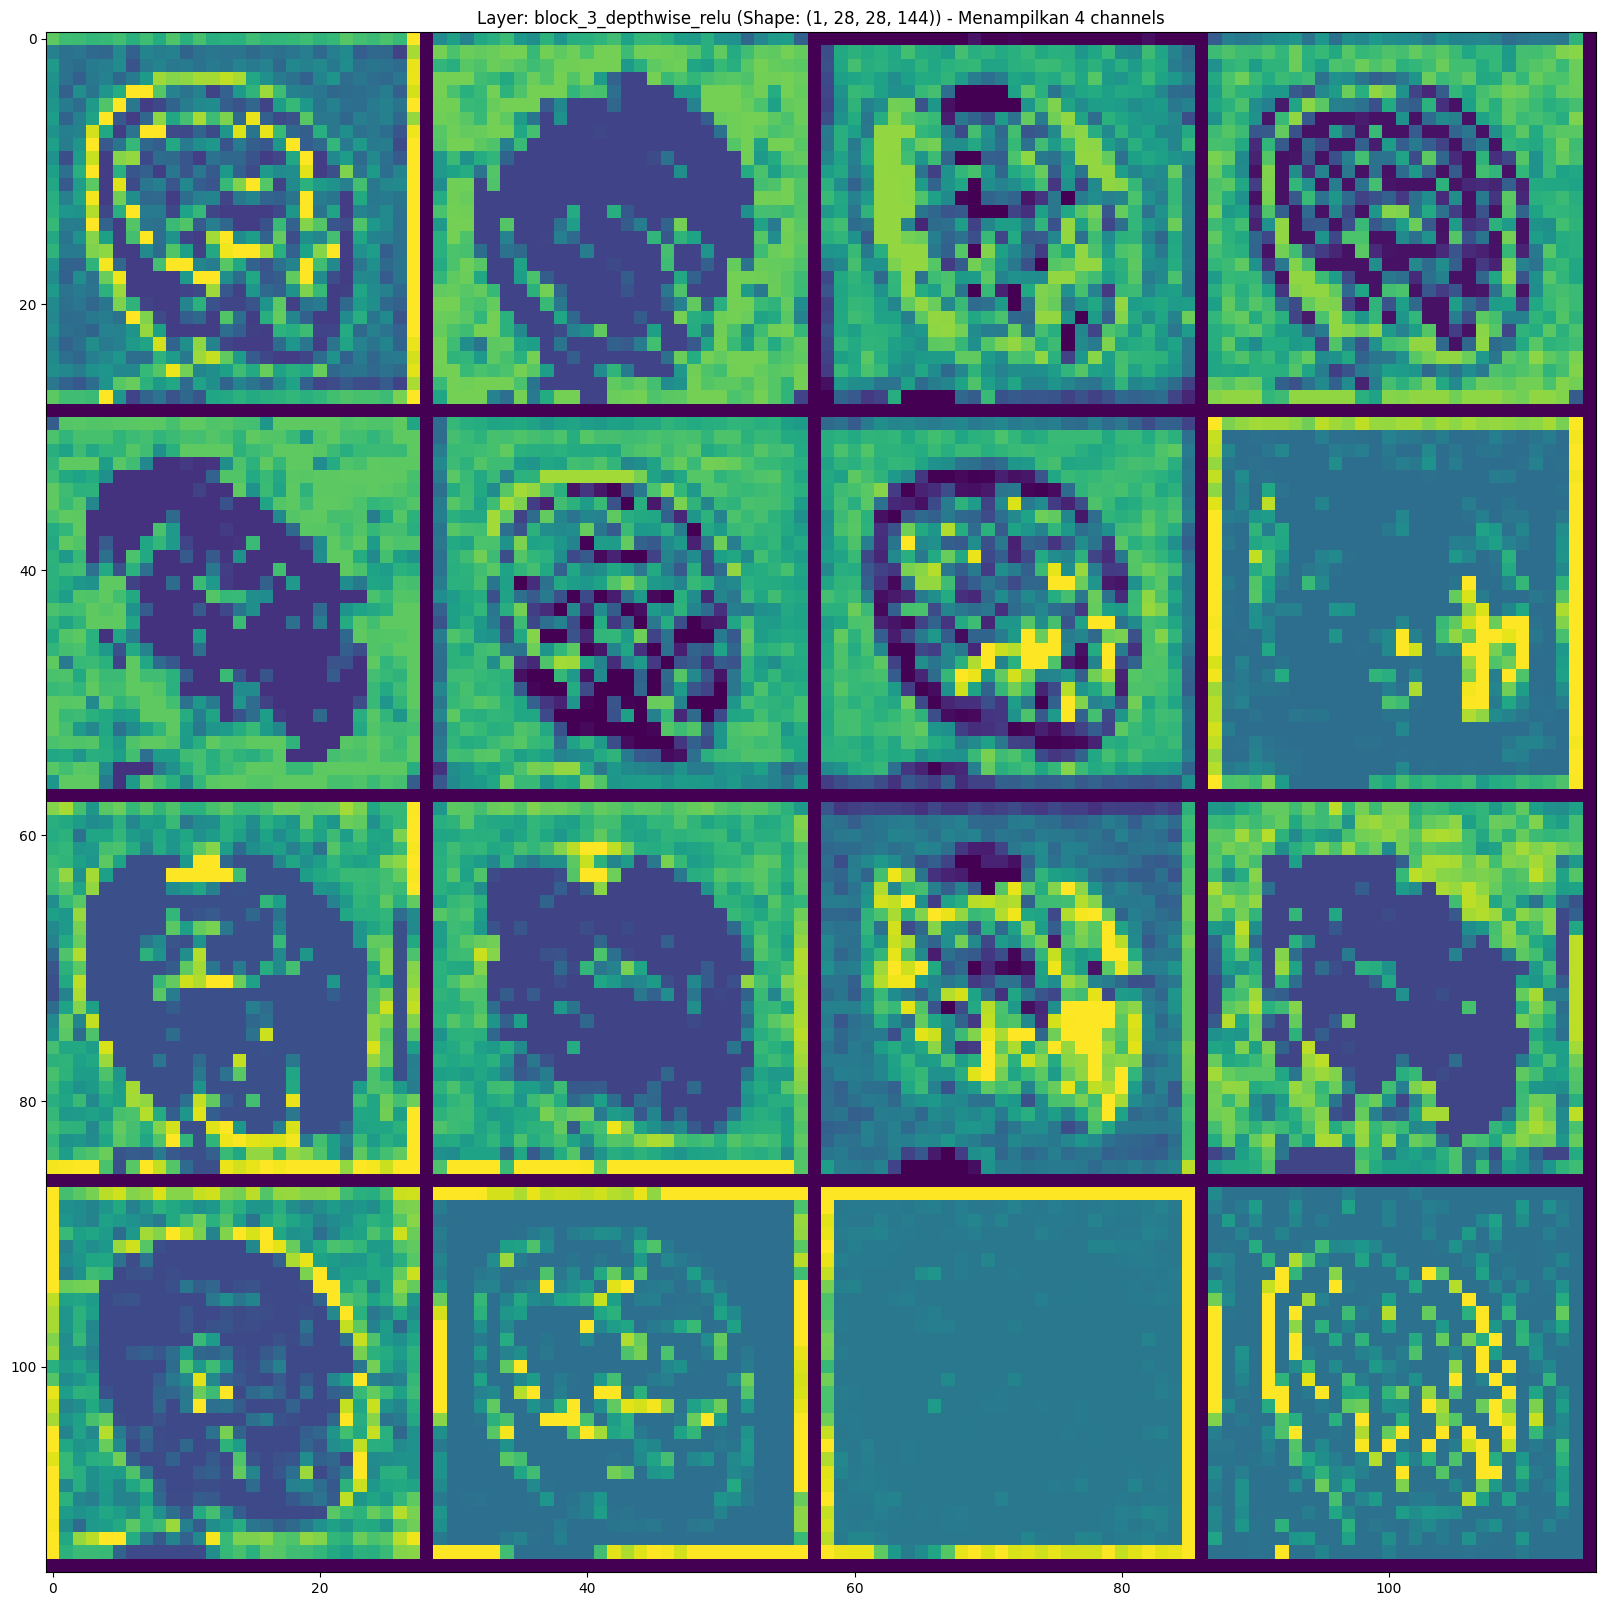

**Penjelasan (block_3_depthwise_relu):** Ini adalah layer di blok-blok awal MobileNetV2.
Model mulai menggabungkan fitur-fitur dasar (tepi, tekstur) dari layer sebelumnya.
Fitur di sini masih cukup sederhana, mungkin merepresentasikan sudut, lengkungan yang lebih kompleks, atau area dengan tekstur tertentu.

ANALISIS LAYER: block_6_project_BN


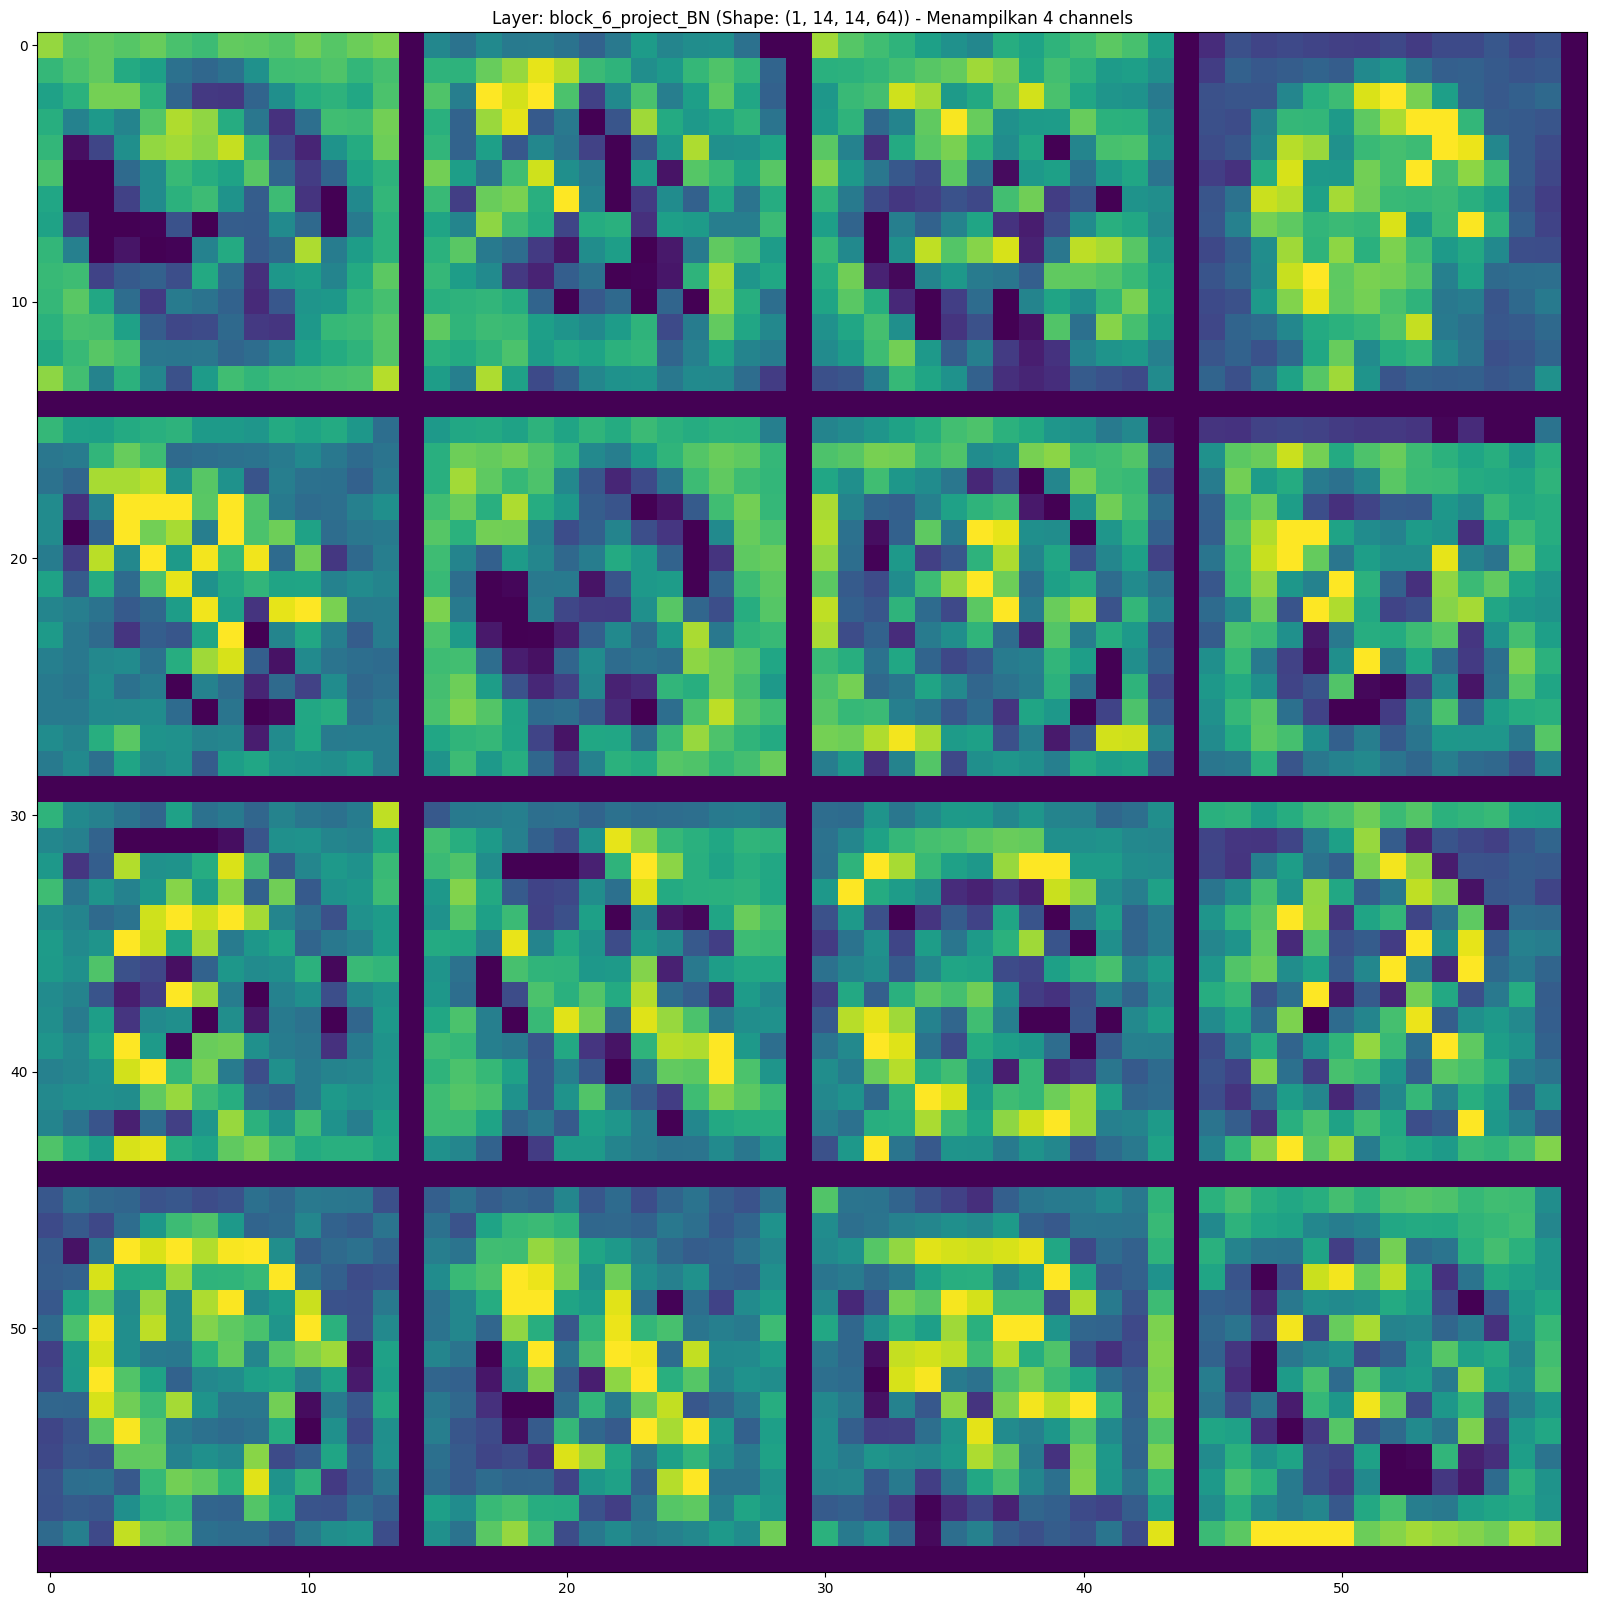

**Penjelasan (block_6_project_BN):** Ini adalah output dari *Pointwise Convolution* (1x1) untuk 'proyeksi'.
Layer ini mengurangi jumlah channel kembali (misalnya dari 192 ke 32).
Ini adalah langkah efisiensi yang merangkum fitur-fitur yang telah dipelajari di channel yang lebih banyak kembali ke representasi yang lebih ringkas.

ANALISIS LAYER: block_13_expand_relu


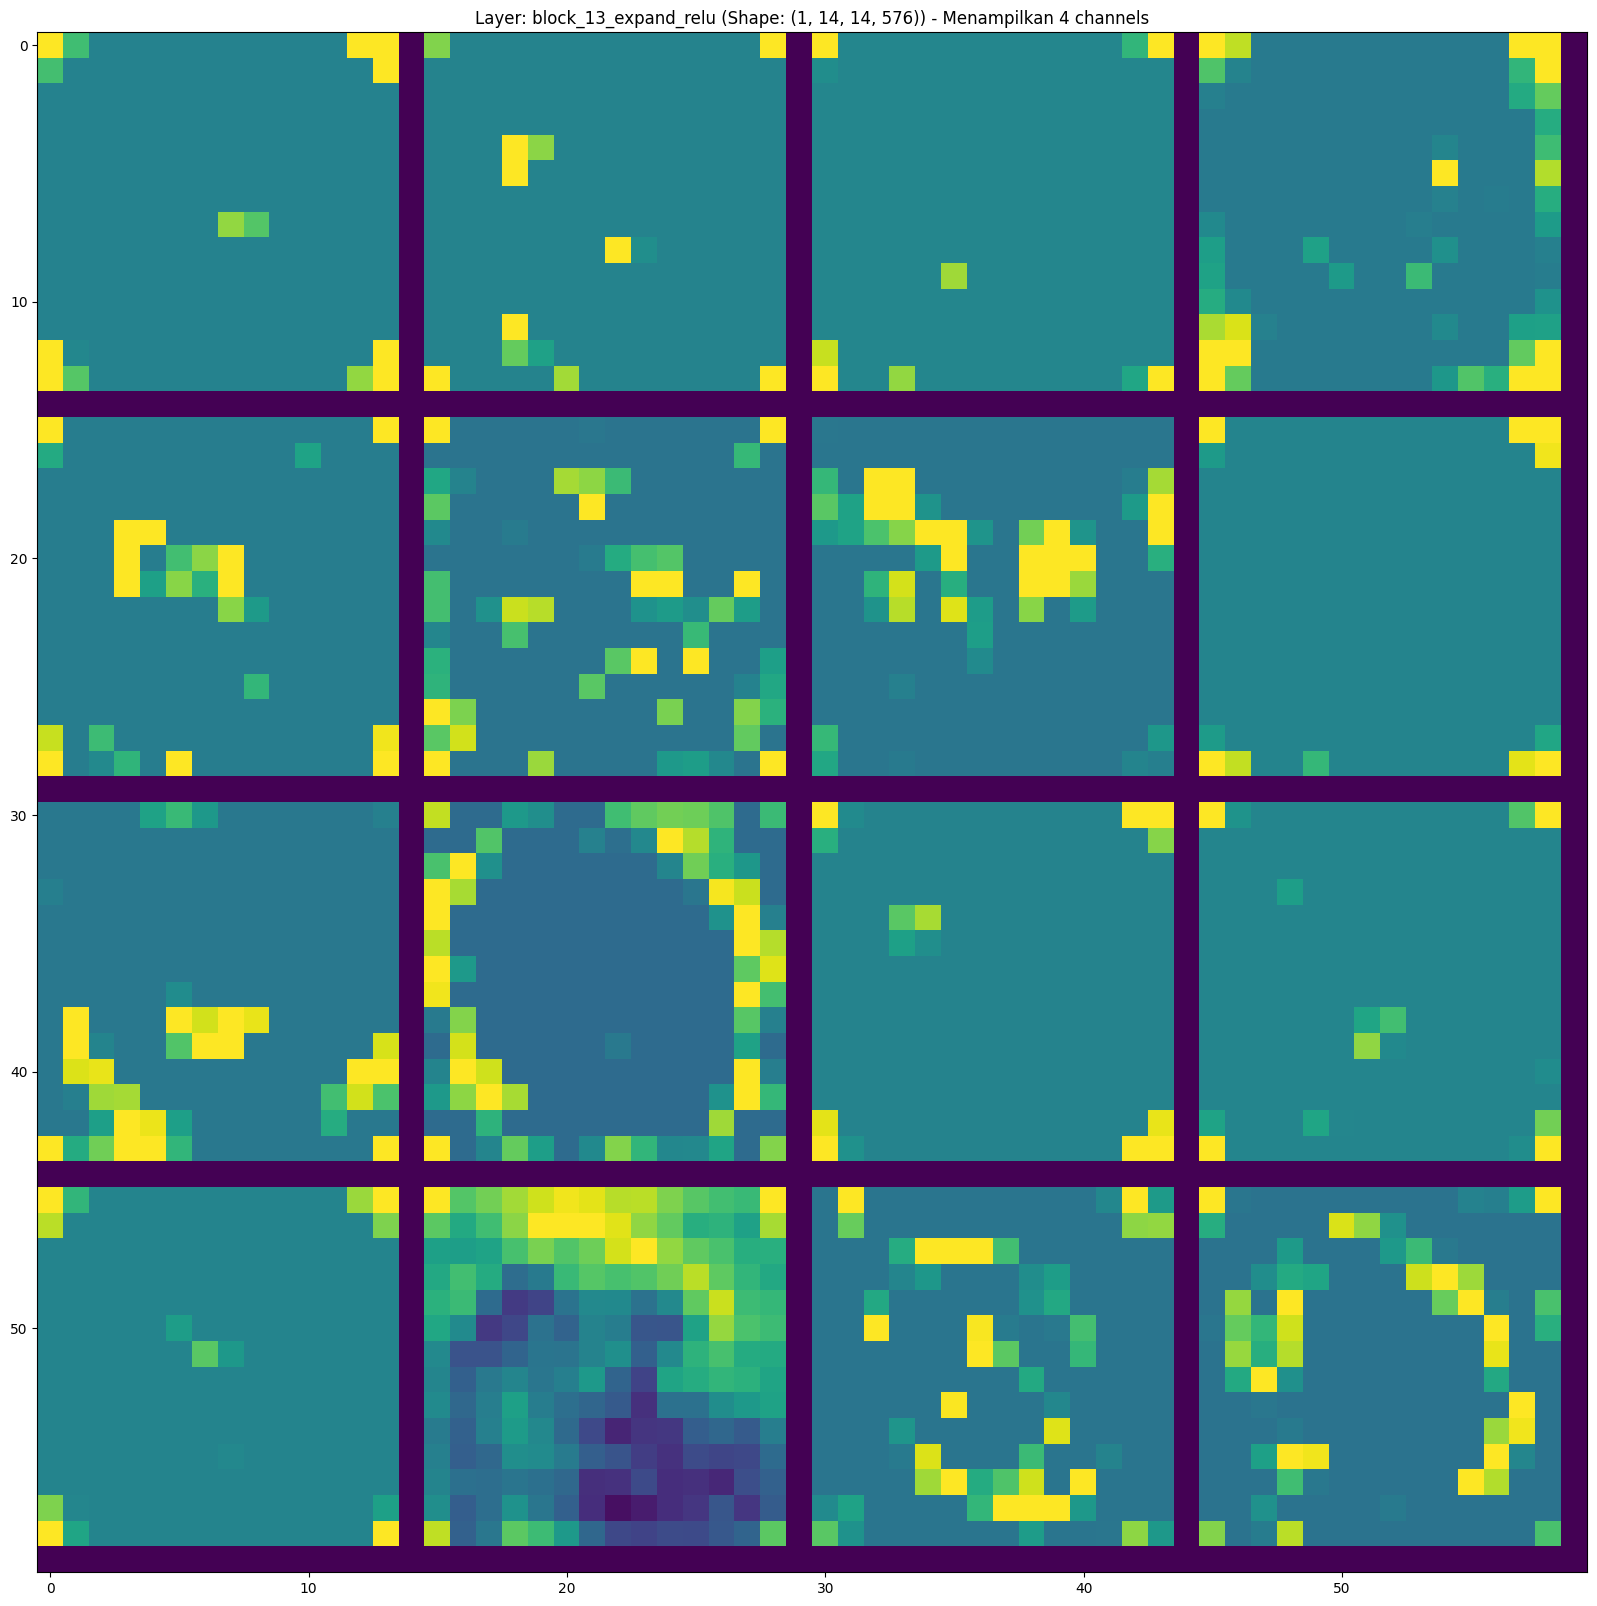

**Penjelasan (block_13_expand_relu):** Ini adalah output dari *Pointwise Convolution* (1x1) untuk 'ekspansi'.
Layer ini memperbanyak jumlah channel (dimensi kedalaman), misalnya dari 32 ke 192.
Tujuannya adalah memberikan 'ruang' lebih bagi layer *depthwise* berikutnya untuk mempelajari lebih banyak fitur spasial.
Visualisasinya menunjukkan bagaimana model memproyeksikan informasi ke dimensi yang lebih tinggi.

ANALISIS LAYER: out_relu


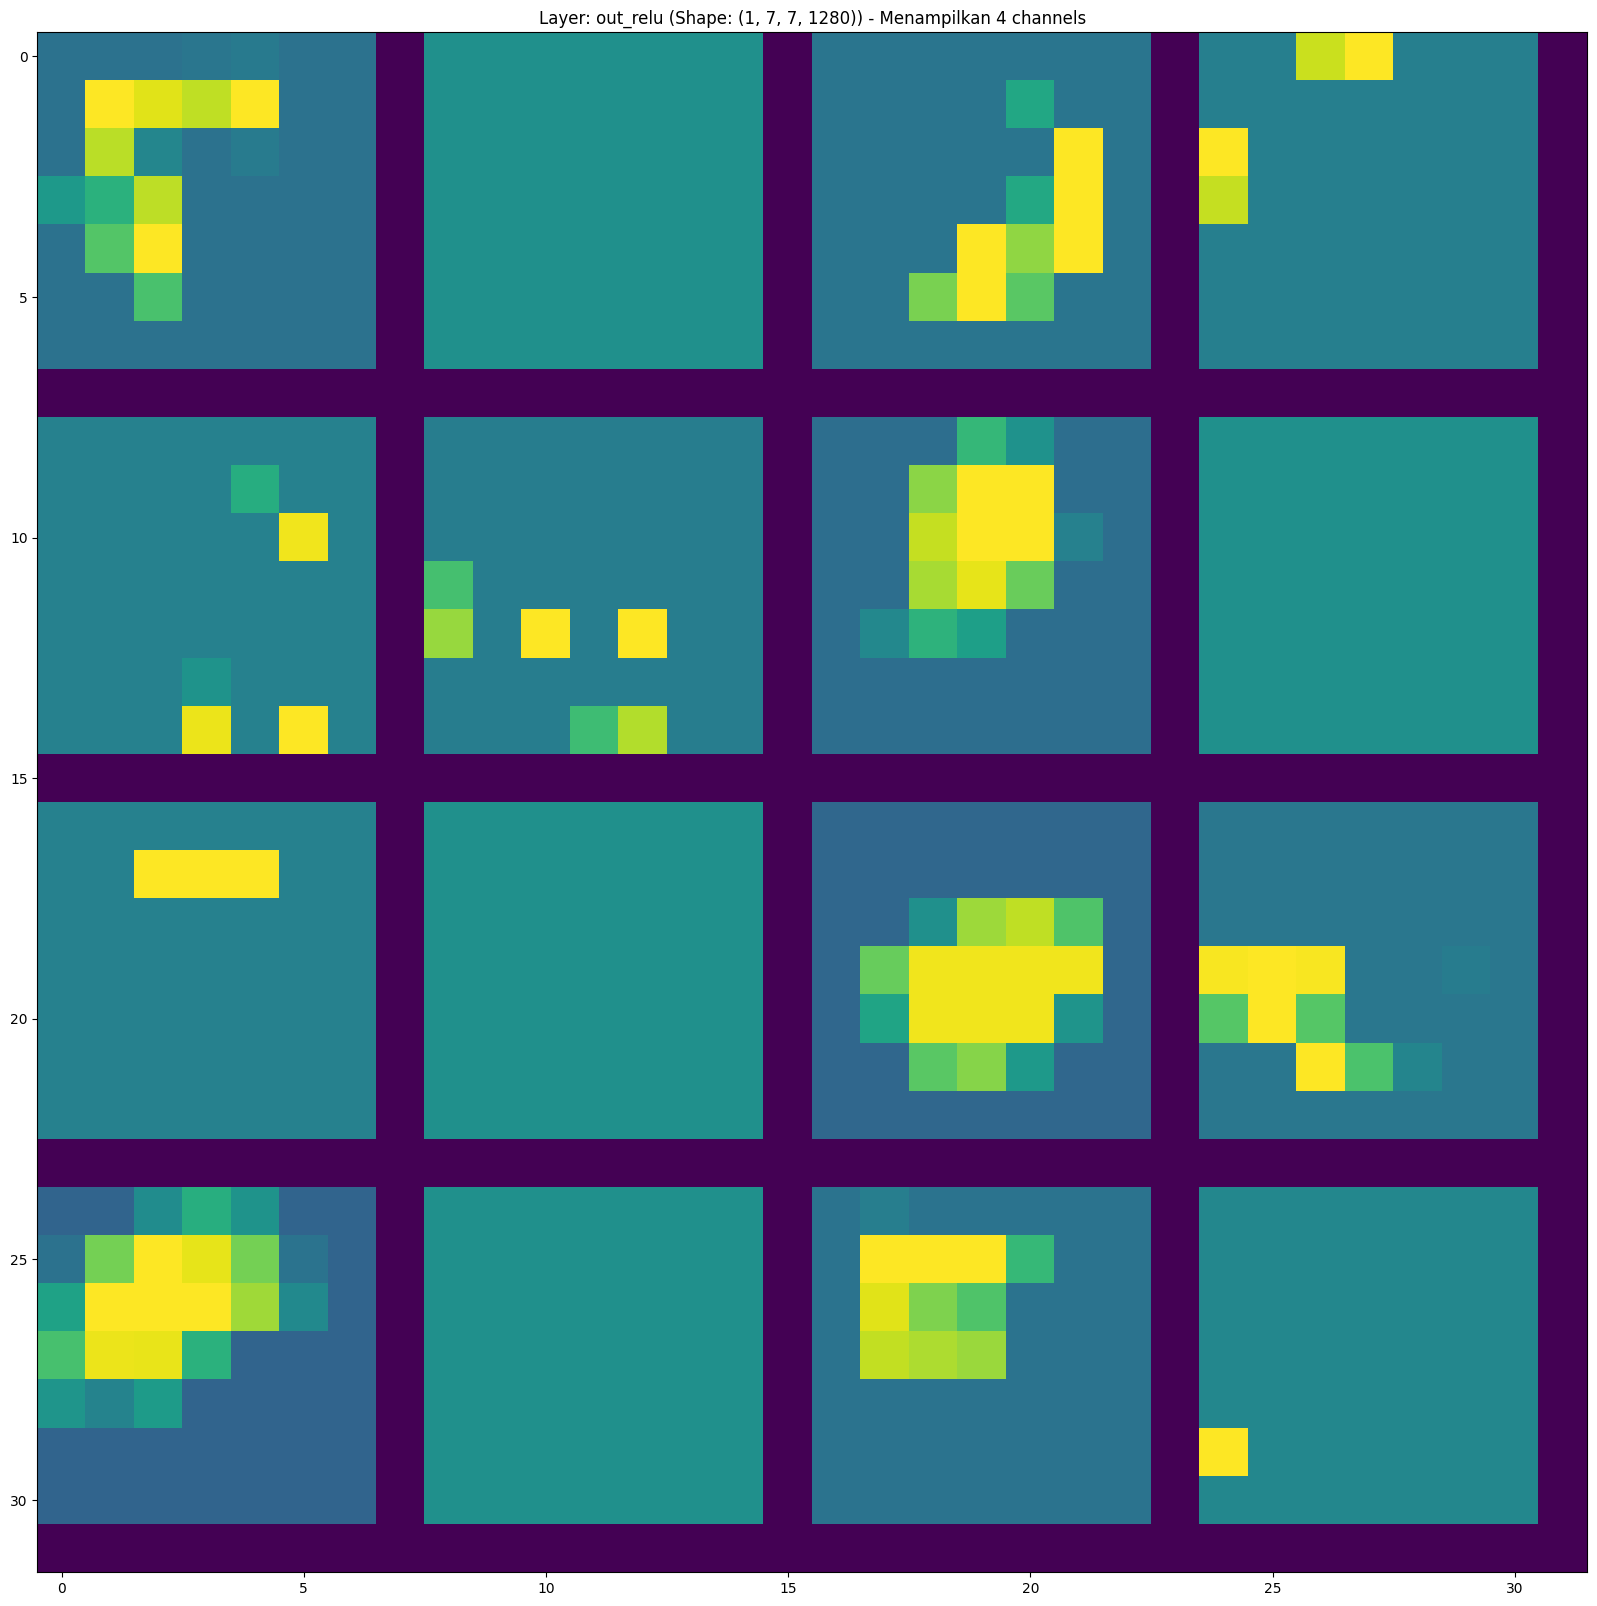

**Penjelasan (out_relu):** Ini adalah layer di bagian akhir (dalam) dari model.
Ini adalah fitur-fitur paling abstrak dan tingkat tinggi sebelum akhirnya dirata-ratakan (jika menggunakan `pooling='avg'`).
Setiap channel di sini merepresentasikan konsep yang sangat spesifik yang relevan untuk klasifikasi (misal, 'adanya indikasi glioma' atau 'struktur normal otak').
Inilah fitur-fitur yang kemudian akan digunakan oleh Random Forest dan XGBoost untuk membuat keputusan akhir.


In [21]:
# Fungsi untuk memproses dan menampilkan grid feature map
def display_feature_maps(feature_map, layer_name, grid_size=8):
    # feature_map punya shape (1, height, width, channels)
    n_features = feature_map.shape[-1]  # Jumlah channels
    size = feature_map.shape[1]         # Ukuran (height/width)
    
    # Kita hanya akan plot 'grid_size x grid_size' channel pertama (misal 8x8 = 64)
    n_cols = max(1, 4)
    n_rows = max(1, 4)
     
    # Buat kanvas untuk menampilkan grid
    display_grid = np.zeros(((size + 1) * n_rows, (size + 1) * n_cols))
    
    feature_idx = 0
    for row in range(n_rows):
        for col in range(n_cols):
            if feature_idx < n_features:
                # Ambil 1 channel
                x = feature_map[0, :, :, feature_idx]
                
                # Post-process agar mudah divisualisasikan
                x -= x.mean()
                x /= (x.std() + 1e-5) # hindari / 0
                x *= 64
                x += 128
                x = np.clip(x, 0, 255).astype('uint8')
                
                # Masukkan ke grid
                display_grid[row * (size + 1) : (row + 1) * size + row, 
                             col * (size + 1) : (col + 1) * size + col] = x
                feature_idx += 1
                
    # Tampilkan grid
    scale = 20. / n_cols
    plt.figure(figsize=(scale * n_cols, scale * n_rows))
    plt.title(f"Layer: {layer_name} (Shape: {feature_map.shape}) - Menampilkan {n_cols} channels")
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    plt.show()

# --- Loop Utama untuk Visualisasi dan Penjelasan ---

for layer_name, feature_map in zip(layer_names, feature_maps):
    print(f"\n" + "="*30)
    print(f"ANALISIS LAYER: {layer_name}")
    print("="*30)
    
    # Tampilkan visualisasi feature map
    display_feature_maps(feature_map, layer_name, grid_size=8)
    
    # --- PENJELASAN (seperti yang Anda minta) ---
    if 'Conv1' in layer_name:
        print(f"**Penjelasan ({layer_name}):** Ini adalah output dari layer konvolusi standar pertama.")
        print("Keluaran ini menunjukkan fitur-fitur paling dasar yang dideteksi model.")
        print("Setiap kotak kecil (channel) fokus pada pola sederhana yang berbeda, seperti:")
        print("  - Detektor tepi (garis lurus, lengkungan)")
        print("  - Detektor tekstur (pola berulang, bintik-bintik)")
        print("  - Detektor gradien warna atau kecerahan.")
        print("Banyak channel mungkin terlihat kosong (hitam) jika fitur tersebut tidak aktif pada gambar ini.")
        
    elif 'block_1_' in layer_name or 'block_3_' in layer_name:
        print(f"**Penjelasan ({layer_name}):** Ini adalah layer di blok-blok awal MobileNetV2.")
        print("Model mulai menggabungkan fitur-fitur dasar (tepi, tekstur) dari layer sebelumnya.")
        print("Fitur di sini masih cukup sederhana, mungkin merepresentasikan sudut, lengkungan yang lebih kompleks, atau area dengan tekstur tertentu.")
        
    elif 'depthwise' in layer_name:
        print(f"**Penjelasan ({layer_name}):** Ini adalah output dari *Depthwise Convolution*.")
        print("Ini adalah inti dari MobileNetV2. Layer ini menerapkan filter terpisah untuk setiap channel input.")
        print("Fungsinya adalah mempelajari **fitur spasial** (pola 'di mana' sesuatu berada) secara efisien tanpa mengubah jumlah channel.")
        
    elif 'expand' in layer_name:
        print(f"**Penjelasan ({layer_name}):** Ini adalah output dari *Pointwise Convolution* (1x1) untuk 'ekspansi'.")
        print("Layer ini memperbanyak jumlah channel (dimensi kedalaman), misalnya dari 32 ke 192.")
        print("Tujuannya adalah memberikan 'ruang' lebih bagi layer *depthwise* berikutnya untuk mempelajari lebih banyak fitur spasial.")
        print("Visualisasinya menunjukkan bagaimana model memproyeksikan informasi ke dimensi yang lebih tinggi.")

    elif 'project' in layer_name:
        print(f"**Penjelasan ({layer_name}):** Ini adalah output dari *Pointwise Convolution* (1x1) untuk 'proyeksi'.")
        print("Layer ini mengurangi jumlah channel kembali (misalnya dari 192 ke 32).")
        print("Ini adalah langkah efisiensi yang merangkum fitur-fitur yang telah dipelajari di channel yang lebih banyak kembali ke representasi yang lebih ringkas.")

    elif 'block_6_' in layer_name:
        print(f"**Penjelasan ({layer_name}):** Ini adalah layer di bagian tengah model.")
        print("Di tahap ini, model sudah mempelajari fitur yang jauh lebih kompleks dan abstrak.")
        print("Fitur-fitur ini sudah sulit diinterpretasi manusia, namun mungkin merepresentasikan:")
        print("  - Bagian-bagian objek yang lebih besar (misal, bagian dari tumor, atau lipatan otak).")
        print("  - Kombinasi tekstur dan bentuk yang spesifik.")
        print("Perhatikan bagaimana *feature map* menjadi lebih kecil (resolusi spasial menurun) namun lebih 'dalam' (banyak channel).")
        
    elif 'block_13_' in layer_name or 'out_relu' in layer_name:
        print(f"**Penjelasan ({layer_name}):** Ini adalah layer di bagian akhir (dalam) dari model.")
        print("Ini adalah fitur-fitur paling abstrak dan tingkat tinggi sebelum akhirnya dirata-ratakan (jika menggunakan `pooling='avg'`).")
        print("Setiap channel di sini merepresentasikan konsep yang sangat spesifik yang relevan untuk klasifikasi (misal, 'adanya indikasi glioma' atau 'struktur normal otak').")
        print("Inilah fitur-fitur yang kemudian akan digunakan oleh Random Forest dan XGBoost untuk membuat keputusan akhir.")

# Batas Testing

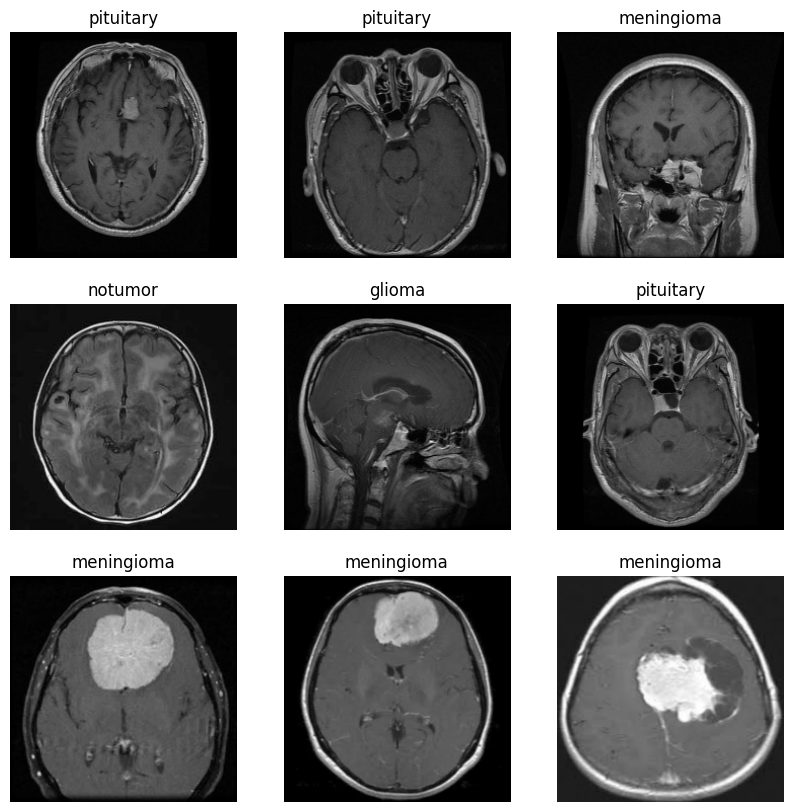

In [13]:
import matplotlib.pyplot as plt

# ambil satu batch dari dataset
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):  # tampilkan 9 gambar pertama
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")
plt.show()

In [16]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# --- 1. Load fitur & label ---
X_train = np.load("X_train.npy")
y_train = np.load("y_train.npy")
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")

print("Data shape:", X_train.shape, X_test.shape)

# --- 2. Training Random Forest ---
print("\nTraining Random Forest...")
rf_clf = RandomForestClassifier(n_estimators=200, random_state=42)
rf_clf.fit(X_train, y_train)

y_pred_rf = rf_clf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Accuracy:", acc_rf)
print("Classification Report (RF):\n", classification_report(y_test, y_pred_rf))

# --- 3. Training XGBoost ---
print("\nTraining XGBoost...")
xgb_clf = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric="mlogloss"
)
xgb_clf.fit(X_train, y_train)

y_pred_xgb = xgb_clf.predict(X_test)
acc_xgb = accuracy_score(y_test, y_pred_xgb)
print("XGBoost Accuracy:", acc_xgb)
print("Classification Report (XGB):\n", classification_report(y_test, y_pred_xgb))

# --- 4. Bandingkan hasil ---
print("\n=== Perbandingan Akurasi ===")
print(f"Random Forest: {acc_rf:.4f}")
print(f"XGBoost      : {acc_xgb:.4f}")

Data shape: (1311, 1280) (5712, 1280)

Training Random Forest...
Random Forest Accuracy: 0.8692226890756303
Classification Report (RF):
               precision    recall  f1-score   support

           0       0.85      0.87      0.86      1321
           1       0.77      0.70      0.73      1339
           2       0.99      0.91      0.95      1595
           3       0.86      0.97      0.91      1457

    accuracy                           0.87      5712
   macro avg       0.86      0.86      0.86      5712
weighted avg       0.87      0.87      0.87      5712


Training XGBoost...


c:\ProgramData\anaconda3\envs\yolov8\lib\site-packages\xgboost\training.py:199: UserWarning: [17:36:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.8807773109243697
Classification Report (XGB):
               precision    recall  f1-score   support

           0       0.85      0.88      0.86      1321
           1       0.77      0.76      0.76      1339
           2       0.99      0.92      0.95      1595
           3       0.90      0.95      0.92      1457

    accuracy                           0.88      5712
   macro avg       0.88      0.88      0.88      5712
weighted avg       0.88      0.88      0.88      5712


=== Perbandingan Akurasi ===
Random Forest: 0.8692
XGBoost      : 0.8808


In [8]:
import joblib

# --- Simpan Model Random Forest ---
joblib.dump(rf_clf, "random_forest_model.pkl")
print("Model Random Forest berhasil disimpan!")

# --- Simpan Model XGBoost ---
joblib.dump(xgb_clf, "xgboost_model.pkl")
print("Model XGBoost berhasil disimpan!")

Model Random Forest berhasil disimpan!
Model XGBoost berhasil disimpan!


Total sample uji: 20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


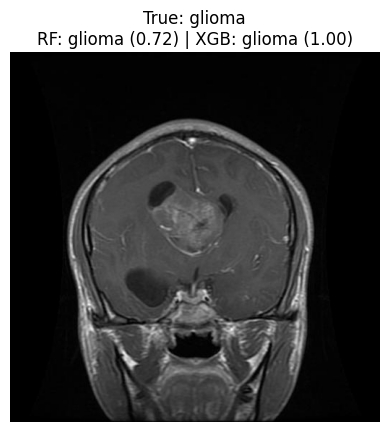

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


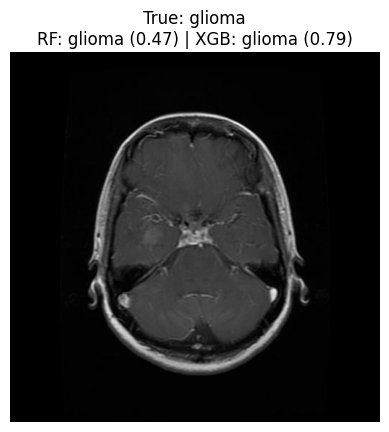

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


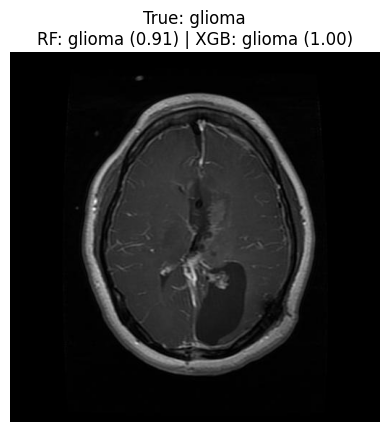

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


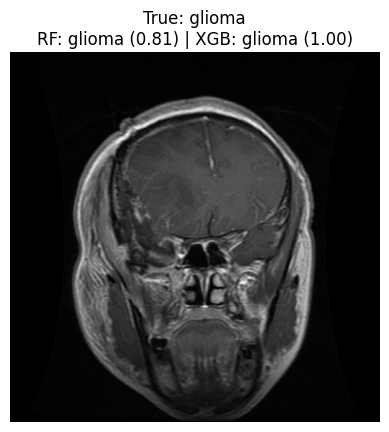

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


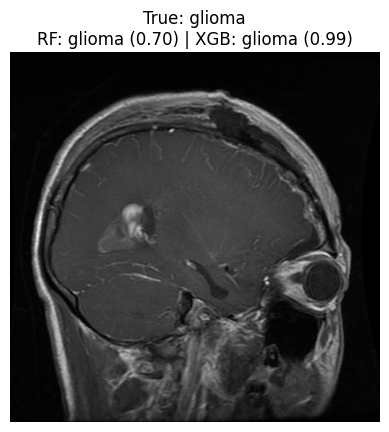

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


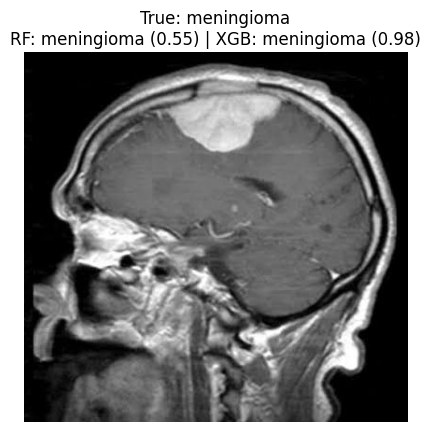

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


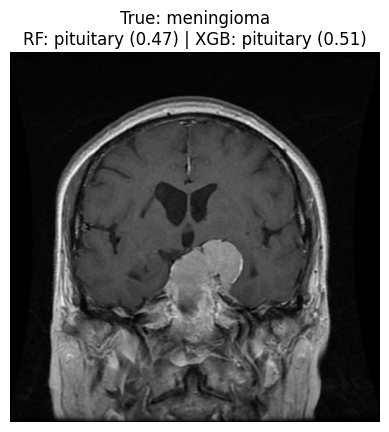

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


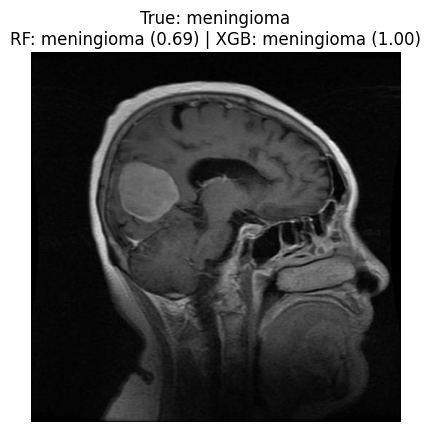

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


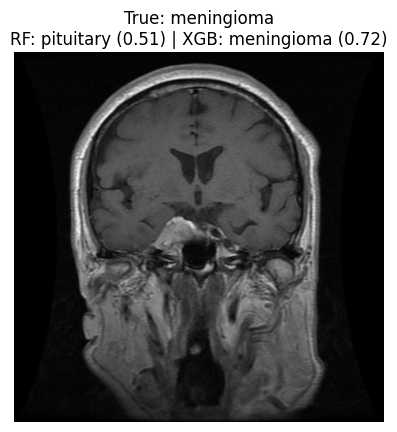

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


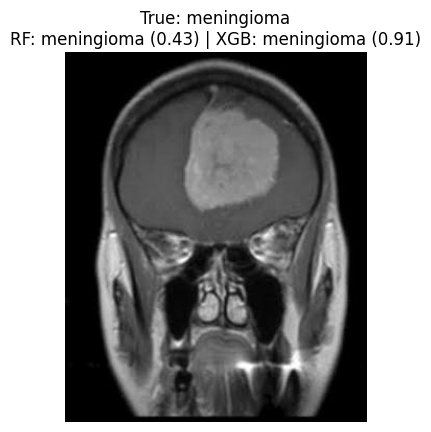

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


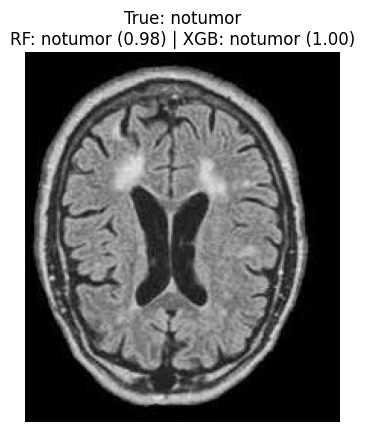

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


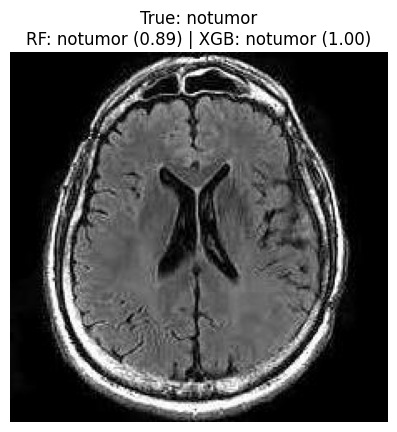

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


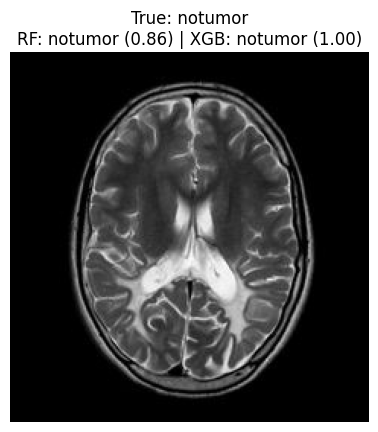

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


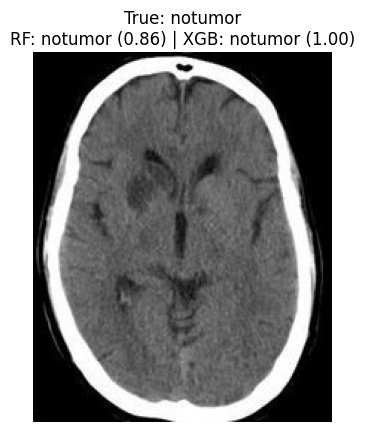

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


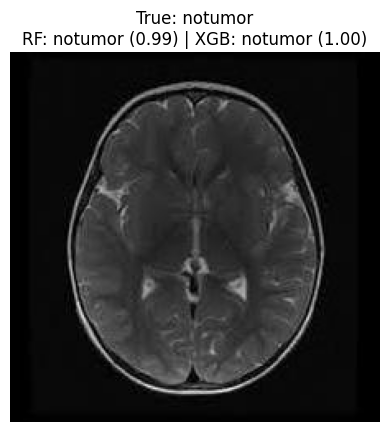

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


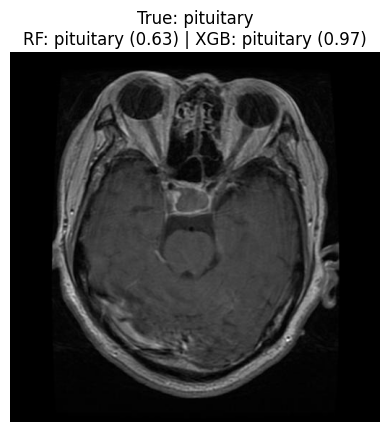

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


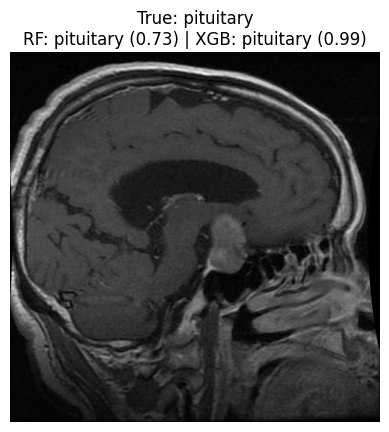

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


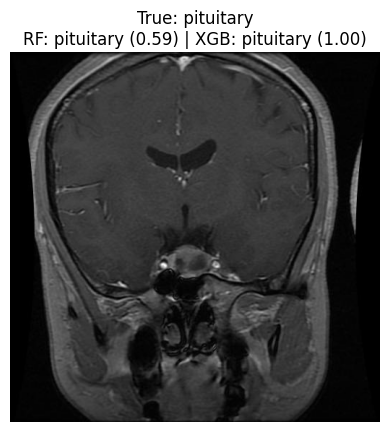

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


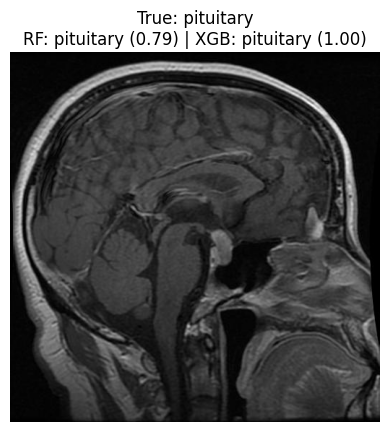

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


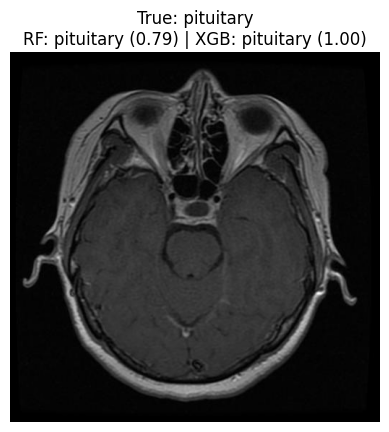


=== Batch Test Results ===
Random Forest Accuracy (batch): 0.9
XGBoost Accuracy (batch): 0.95


In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.metrics import accuracy_score

# === Path ke folder test ===
test_dir = "D:/Mekatronika/Training Tugas Akhir/Dataset/Testing"

# === Fungsi load & preprocess 1 gambar ===
def load_and_preprocess(img_path, target_size=(224,224)):
    img = tf.keras.utils.load_img(img_path, target_size=target_size)
    img_array = tf.keras.utils.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

# === Ambil beberapa gambar dari test set (contoh 20 gambar acak) ===
all_images = []
all_labels = []
for class_name in class_names:  # class_names sudah ada dari dataset
    folder = os.path.join(test_dir, class_name)
    files = os.listdir(folder)
    sample_files = np.random.choice(files, size=5, replace=False)  # ambil 5 gambar per kelas
    for f in sample_files:
        all_images.append(os.path.join(folder, f))
        all_labels.append(class_name)

print(f"Total sample uji: {len(all_images)}")

# === Prediksi dengan RF & XGB ===
rf_preds, rf_probs = [], []
xgb_preds, xgb_probs = [], []

for i, img_path in enumerate(all_images):
    # preprocess & ekstraksi fitur
    img_array = load_and_preprocess(img_path)
    features = base_model.predict(img_array)

    # prediksi RF
    pred_rf = rf_clf.predict(features)[0]
    proba_rf = rf_clf.predict_proba(features)[0]

    # prediksi XGB
    pred_xgb = xgb_clf.predict(features)[0]
    proba_xgb = xgb_clf.predict_proba(features)[0]

    rf_preds.append(class_names[pred_rf])
    rf_probs.append(proba_rf)

    xgb_preds.append(class_names[pred_xgb])
    xgb_probs.append(proba_xgb)

    # tampilkan hasil 1 gambar (opsional visualisasi)
    plt.imshow(tf.keras.utils.load_img(img_path))
    plt.title(f"True: {all_labels[i]}\nRF: {class_names[pred_rf]} ({max(proba_rf):.2f}) | XGB: {class_names[pred_xgb]} ({max(proba_xgb):.2f})")
    plt.axis("off")
    plt.show()

# === Hitung akurasi sederhana ===
rf_acc = accuracy_score(all_labels, rf_preds)
xgb_acc = accuracy_score(all_labels, xgb_preds)

print("\n=== Batch Test Results ===")
print("Random Forest Accuracy (batch):", rf_acc)
print("XGBoost Accuracy (batch):", xgb_acc)